In [415]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

### Data import and exploration

In [264]:
data = pd.read_csv("data\\train.csv")

In [972]:
test = pd.read_csv("data\\test.csv")

In [4]:
data.isnull().sum()

# The data doesn't have in null values

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [5]:
data.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.53,Very Good,G,SI1,63.4,54.0,5.09,5.13,3.24,7.057
1,1,0.41,Ideal,D,SI1,63.0,56.0,4.80,4.75,3.01,6.824
2,2,0.32,Ideal,I,VS2,61.6,56.0,4.37,4.39,2.70,6.107
3,3,0.31,Ideal,H,VVS2,61.2,56.0,4.34,4.37,2.66,6.390
4,4,1.35,Premium,J,VS2,60.5,56.0,7.19,7.12,4.33,8.741


In [265]:
data = data.set_index('id')

In [973]:
test = test.set_index('id')

In [8]:
data.dtypes

# It seems like we have three categorical variables, which we will have to modify whne we are fitting our model

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

### Correlation matrix

#### Before creating any models, it is important ot understad how variables interact between them and is their relantion. In order to do this, I 'm going to create a heatmap of the correlation matrix 


- id: only for test & sample submission files, id for prediction sample identification
- price: price in USD
- carat: weight of the diamond
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour
- clarity: a measurement of how clear the diamond is
- x: length in mm
- y: width in mm
- z: depth in mm
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

<AxesSubplot:>

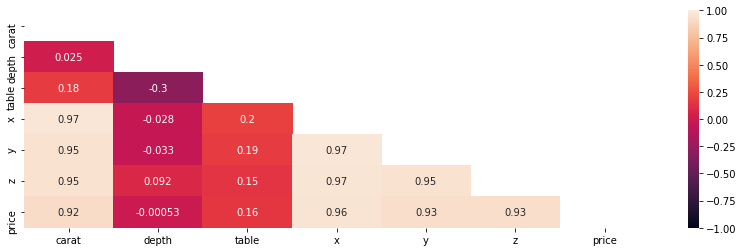

In [102]:
plt.figure(figsize=(14, 4))

mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

sns.heatmap(data.corr(), vmin=-1, vmax=1, mask=mask, annot=True )

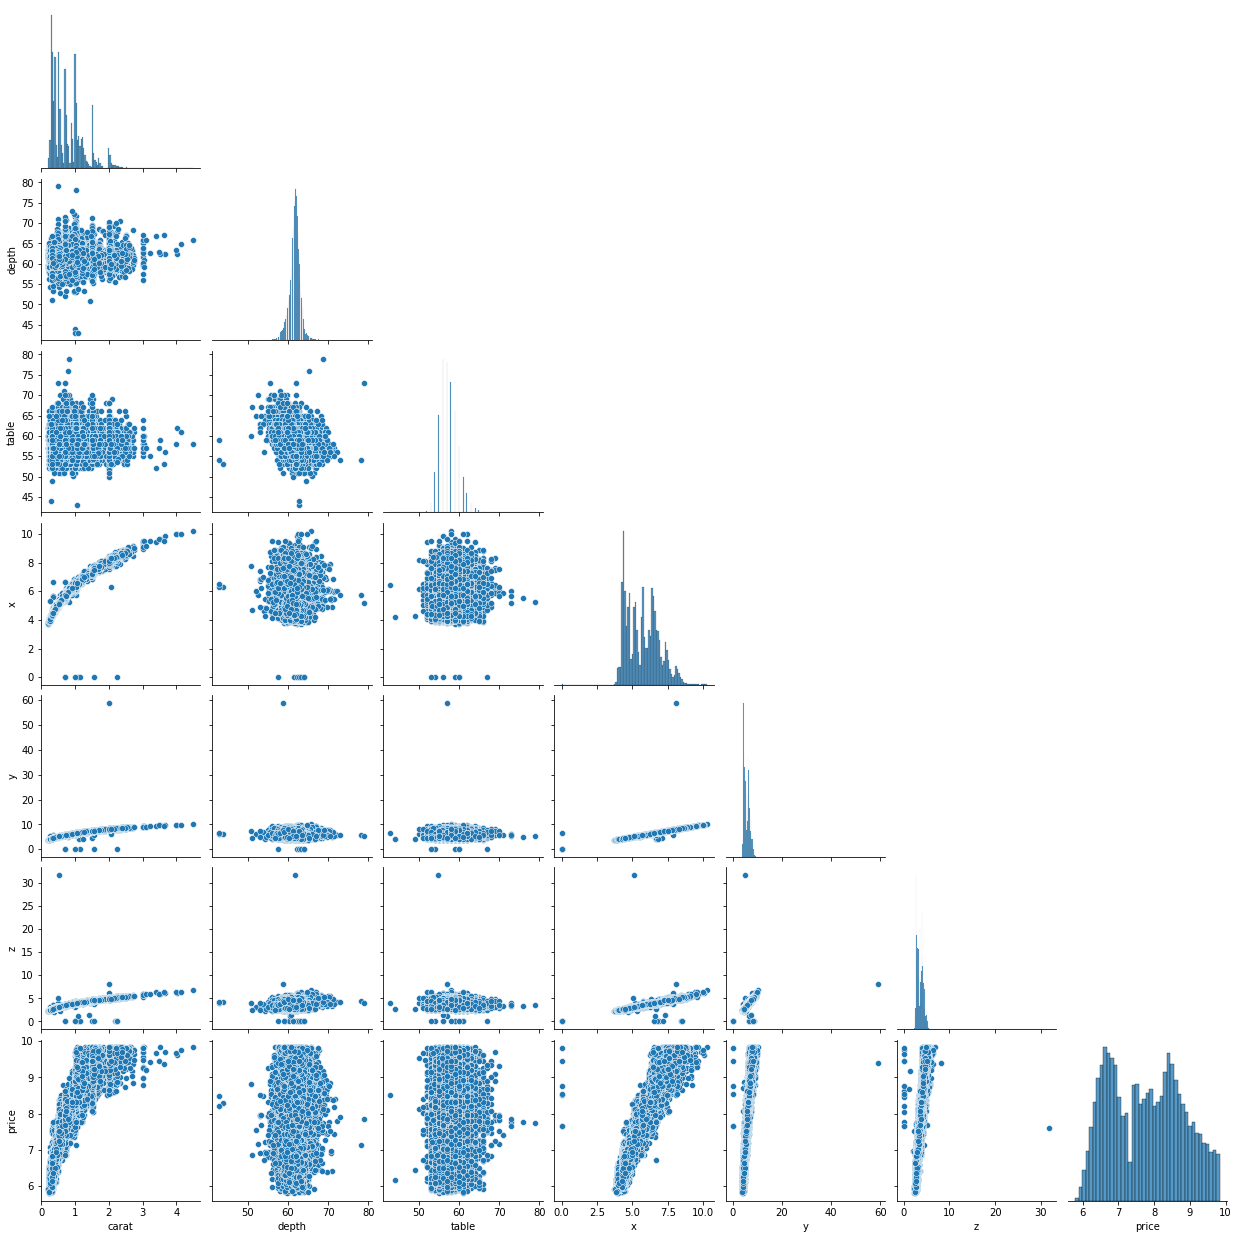

In [103]:
sns.pairplot(data, corner = True)

#### From this plot we can see, as the correlation matrix showed, that depth and table have no correlation with price. Also, it can be seen that in variables, x, y and z there are a few outliers, which we could delete

#### FInding outliers

c:\users\juanp\anaconda3\envs\ironhack\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='z', ylabel='price'>

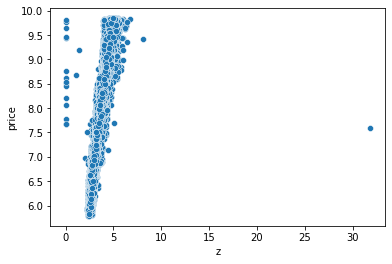

In [104]:
sns.scatterplot(data.z, data.price)

In [105]:
def outliers(series):

    q3, q1 = np.percentile(series, [75 ,25])

    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)

    upper_bound = q3 + (1.5 * iqr)

    lista = []

    for i in series:

        if i > upper_bound or i < lower_bound:
            lista.append(i)

    return [len(lista),round(lower_bound,2), round(upper_bound,2)]
    

In [133]:
outliers(prueba.table)

[456, 51.5, 63.5]

In [268]:
data = data.drop(data[(data.x < 1.98) & (data.y < 2.0) & (data.z < 1.23)].index)

In [270]:
data = data.drop(data[(data.y > 20) & (data.z > 10)].index)

In [271]:
data = data.drop(data[data.carat > 2.5].index)

In [273]:
data = data.drop(data[(data.depth < 50) & (data.depth > 74)].index)

In [275]:
data = data.drop(data[(data.table < 50) & (data.table > 70)].index)

In [276]:
data.shape

(40334, 10)

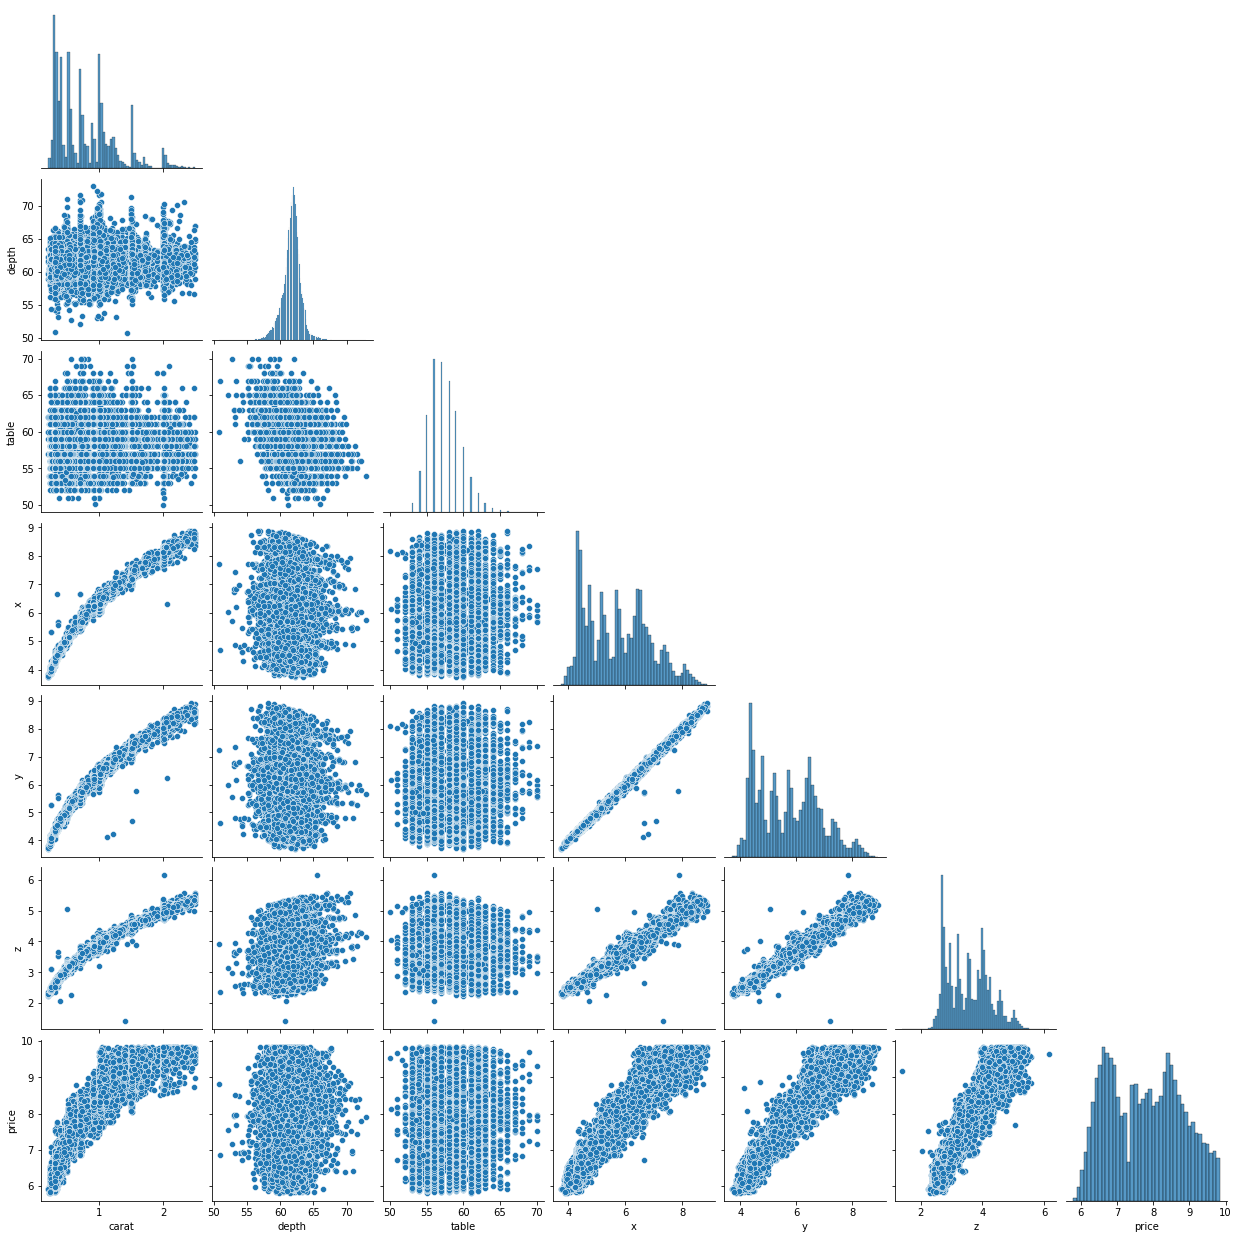

In [212]:
sns.pairplot(data, corner = True)

### Split between X variables and target variable

### Let's change our categorical values 

#### We can differentiate between two types of actegoricla variables:
    - Ordinal -> cut (order matters)
    - Nominal -> color and clarity (order doesn't matter)

In [341]:
# For the ordinal variable we have to use the OrdinalEncoder from the sklearn preprocessiong module

encoder = OrdinalEncoder()

data.cut = encoder.fit_transform(data.cut.values.reshape(-1, 1))

# Now, our values have changed to match a list beweten 0 and 4

In [974]:
test.cut = encoder.fit_transform(test.cut.values.reshape(-1, 1))

In [342]:
# For the nominal variables we use the get_dummies from pandas

nominal = pd.get_dummies(data[["color", "clarity"]], drop_first=True)

data = pd.concat([data, nominal], axis = 1)

data = data.drop(["color", "clarity"], axis = 1)

In [975]:
nominal_test = pd.get_dummies(test[["color", "clarity"]], drop_first=True)

test = pd.concat([test, nominal_test], axis = 1)

test = test.drop(["color", "clarity"], axis = 1)

### Train-test split

#### For this project I'm going to split the data in 80% trainning and 20% testing

In [689]:
X =data.drop(["price"], axis = 1)
y = data.price

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=150)

### Standarization 

In [575]:
scaler = StandardScaler()

scaler.fit(X)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

### Model Evaluation

#### Basic Linear Regression

In [910]:
data.columns

Index(['carat', 'cut', 'depth', 'table', 'x', 'y', 'z', 'price', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [912]:
data

,carat,cut,depth,table,x,y,z,price,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,,,,,,,,,,,,,,,,,,,,,
0,0.53,4.0,63.4,54.0,5.09,5.13,3.24,7.057,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.41,2.0,63.0,56.0,4.80,4.75,3.01,6.824,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.32,2.0,61.6,56.0,4.37,4.39,2.70,6.107,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.31,2.0,61.2,56.0,4.34,4.37,2.66,6.390,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1.35,3.0,60.5,56.0,7.19,7.12,4.33,8.741,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0.52,3.0,61.2,58.0,5.16,5.20,3.17,7.508,0,0,...,0,0,0,0,0,0,0,1,0,0
40451,0.52,2.0,62.0,55.0,5.14,5.17,3.19,7.232,0,1,...,0,0,0,0,1,0,0,0,0,0
40452,0.73,4.0,63.5,58.0,5.68,5.72,3.62,8.065,0,0,...,0,0,0,0,0,0,0,1,0,0


In [956]:
data = data.drop(["y", "z"], axis = 1)

In [976]:
X = data.drop(["price"], axis = 1)
y = data.price

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=150)

In [977]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mean_squared_error(y_test, y_pred)

0.0194899038944075

In [982]:
test = test.drop(["y", "z"], axis = 1)

In [980]:
X_train.shape

(32267, 18)

In [983]:
test

,carat,cut,depth,table,x,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
id,,,,,,,,,,,,,,,,,,
0,0.33,2.0,61.9,55.0,4.44,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0.41,2.0,61.8,54.0,4.79,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.91,4.0,62.5,59.0,6.16,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0.42,4.0,62.6,57.0,4.76,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.54,2.0,61.5,56.0,5.28,0,0,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,0.55,2.0,61.7,56.4,5.26,0,1,0,0,0,0,0,1,0,0,0,0,0
13481,1.12,3.0,60.6,59.0,6.77,0,0,0,1,0,0,0,0,0,0,1,0,0
13482,0.37,2.0,61.5,57.0,4.63,0,0,0,0,0,0,0,1,0,0,0,0,0


In [987]:
pred = lr.predict(X_test)

In [985]:
test["price"] = pred

In [988]:
mean_squared_error(y_test, pred)

0.0194899038944075

In [295]:
submission_1 = test["price"]

In [296]:
submission_1.to_csv("predictions\\submission_1")

### Second model

In [990]:
results = []

for depth in range(1,18):
    model = DecisionTreeRegressor(max_depth=depth, min_samples_split = 500)
    model.fit(X_train, y_train)
    
    result = {
        "depth": depth,
        "train_error": mean_squared_error(y_train, model.predict(X_train)),
        "test_error": mean_squared_error(y_test, model.predict(X_test))
    }
    
    results.append(result)

In [991]:
dt = DecisionTreeRegressor(max_depth=15)

dt.fit(X_train, y_train)

pred_tree = dt.predict(X_test)

In [992]:
mean_squared_error(y_test, pred_tree)

0.01951971376707471

In [993]:
test = test.drop("price", axis = 1)

In [1000]:
pred_tree = dt.predict(X_test)

In [995]:
prueba = pd.DataFrame({"price":y_test,"linear_pred": lr.predict(X_test), "forest_pred": dt.predict(X_test)})
results = pd.DataFrame({"id":test.index,"linear_pred": lr.predict(test), "forest_pred": dt.predict(test)})
results["price"] = (results.linear_pred * 0.6 + results.forest_pred * 0.4)

In [1001]:
mean_squared_error(y_test, pred_tree)

0.01951971376707471

In [619]:
submission_2 = results.drop(["linear_pred", "forest_pred"], axis =1)

In [625]:
submission_2.to_csv("predictions\\submission_2")

In [629]:
submission_3 = results.drop(["linear_pred", "forest_pred"], axis =1)

In [632]:
submission_3.to_csv("predictions\\submission_3")

### Modelo 3 - Join variables

In [767]:
X =data.drop(["price"], axis = 1)
y = data.price

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=150)

In [768]:
lr.fit(X_train, y_train)
lr.predict(X_test)

array([8.43044674, 8.48692844, 7.53757124, ..., 7.99175534, 6.42287238,
       6.74923743])

In [1002]:
model = DecisionTreeRegressor()
parameter_space = {
                   'max_depth': [19, 20, 21],
                   'min_samples_split': [43, 44, 45, 46, 47],
                   'min_samples_leaf': [2,3,4],
                   'max_features': [17]                                    
                  }

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           verbose=1,
                           n_jobs=-1,
                           cv=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    7.2s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [19, 20, 21], 'max_features': [17],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [43, 44, 45, 46, 47]},
             verbose=1)

In [1003]:
grid_search.best_score_

0.9820527849014873

In [1004]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 45}

In [1005]:
dt_3 = DecisionTreeRegressor(max_depth = 18, max_features = 16, min_samples_leaf = 5, min_samples_split = 50)

In [1006]:
dt_3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=18, max_features=16, min_samples_leaf=5,
                      min_samples_split=50)

In [1007]:
pred = dt_3.predict(X_test)

In [1008]:
mean_squared_error(y_test, pred)

0.01841572655841646

In [1009]:
prueba = pd.DataFrame({"price":y_test,"linear_pred": lr.predict(X_test), "forest_pred": dt_3.predict(X_test)})
results = pd.DataFrame({"id":test.index,"linear_pred": lr.predict(test), "forest_pred": dt_3.predict(test)})


In [1010]:
prueba.head()

,price,linear_pred,forest_pred
id,,,
33699,8.369,8.441616,8.144526
15487,8.448,8.467997,8.565515
33830,7.624,7.513031,7.544026
3762,7.733,8.185674,8.043923
33583,9.215,9.115460,9.314075


In [870]:
prueba["pred"] = (prueba.linear_pred * 0.3 + prueba.forest_pred * 0.7)

In [807]:
results["price"] = (results.linear_pred * 0.3 + results.forest_pred * 0.7)

In [813]:
submission_4 = results.drop(["linear_pred", "forest_pred"], axis =1)

In [815]:
submission_4 = submission_4.set_index('id')

In [817]:
submission_4.to_csv("predictions\\submission_4")

### Model 4

c:\users\juanp\anaconda3\envs\ironhack\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price', ylabel='carat'>

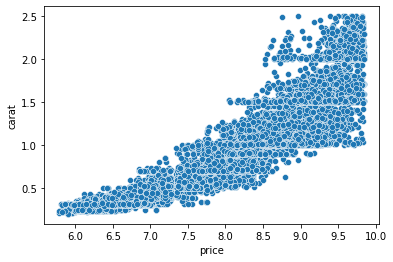

In [883]:
sns.scatterplot(data.price, data.carat)

In [890]:
X =test.drop(["price"], axis = 1)
y = test.price

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=150)

In [1011]:
test = data.copy()

test["carat_log"] = np.exp(data.carat)

test = test.drop("carat", axis = 1)

In [1012]:
model = DecisionTreeRegressor()
parameter_space = {
                   'max_depth': [21, 22, 23, 24, 25],
                   'min_samples_split': [41, 42, 43, 44],
                   'min_samples_leaf': [2,3,4, 5, 6, 7],
                   'max_features': [18, 19, 20, 21]                                    
                  }

grid_search = GridSearchCV(model,
                           param_grid=parameter_space,
                           verbose=1,
                           n_jobs=-1,
                           cv=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   20.4s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [21, 22, 23, 24, 25],
                         'max_features': [18, 19, 20, 21],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [41, 42, 43, 44]},
             verbose=1)

In [1013]:
grid_search.best_score_


0.9818726820533528

In [1014]:
grid_search.best_params_

{'max_depth': 21,
 'max_features': 18,
 'min_samples_leaf': 3,
 'min_samples_split': 42}